In [1]:
# Install required libraries
!pip install -q scikit-learn pandas numpy tensorflow

--2025-04-11 06:01:31--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  --.-KB/s    in 0.1s    

2025-04-11 06:01:31 (18.5 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]

gzip: kddcup.data_10_percent already exists; do you wish to overwrite (y or n)? n
	not overwritten
Training VAE...
Epoch 1/20, Loss: 1538473.8750
Epoch 2/20, Loss: 47.7924
Epoch 3/20, Loss: 89.6784
Epoch 4/20, Loss: 38.3154
Epoch 5/20, Loss: 61.6178
Epoch 6/20, Loss: 34.1734
Epoch 7/20, Loss: 37.4545
Epoch 8/20, Loss: 30.0806
Epoch 9/20, Loss: 28.0509
Epoch 10/20, Loss: 26.3329
Epoch 11/20, Loss: 24.8796
Epoch 12/20, Loss: 23.4517
Epoch 13/20, Loss: 22.2762
Epoch 1

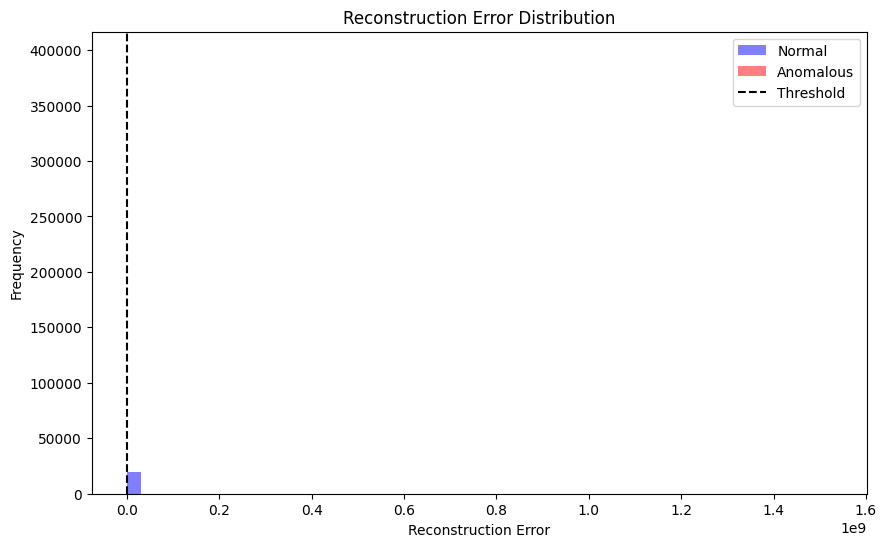

In [14]:
# Import necessary libraries
# On 10 Percent
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Load and preprocess the KDD99 dataset
# Download the KDD99 dataset (10% subset)
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
!gunzip kddcup.data_10_percent.gz

# Read the dataset
data = pd.read_csv('kddcup.data_10_percent', header=None)

# Assign column names (based on KDD99 documentation)
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
data.columns = columns

# Step 2: Preprocess the data
# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Convert labels: 'normal' -> 0, attacks -> 1
data['label_binary'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Drop the original label column
data = data.drop('label', axis=1)

# Split features and labels
X = data.drop('label_binary', axis=1).values
y = data['label_binary'].values

# Normalize the features and ensure float32
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# Split into normal and anomalous data
normal_data = X[y == 0]
anomalous_data = X[y == 1]

# Use normal data for training, split into train/test
X_train, X_test_normal = train_test_split(normal_data, test_size=0.2, random_state=42)

# Combine test normal and anomalous data for evaluation
X_test = np.concatenate([X_test_normal, anomalous_data], axis=0)
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(anomalous_data))], axis=0).astype(np.int32)

# Step 3: Define the Variational Autoencoder
class VAE(Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim)  # Mean + log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * logvar) * eps

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, logvar

# Custom loss function for VAE
def vae_loss(x, x_reconstructed, mean, logvar):
    # Reconstruction loss (MSE)
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_reconstructed), axis=1))
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1))
    return recon_loss + kl_loss

# Step 4: Build and compile the VAE
input_dim = X_train.shape[1]
latent_dim = 8
vae = VAE(input_dim, latent_dim)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = vae(x)
        loss = vae_loss(x, x_reconstructed, mean, logvar)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Step 5: Train the VAE
batch_size = 128
epochs = 20

# Convert training data to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(batch_size)

# Training loop
print("Training VAE...")
for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataset:
        loss = train_step(batch)
        total_loss += loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.numpy()/len(train_dataset):.4f}")

# Step 6: Evaluate anomaly detection
# Compute reconstruction errors on test data
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_reconstructed, _, _ = vae(X_test_tf)
reconstruction_error = tf.reduce_mean(tf.square(X_test_tf - X_reconstructed), axis=1).numpy()

# Determine threshold (95th percentile of normal data errors)
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_train_reconstructed, _, _ = vae(X_train_tf)
train_recon_error = tf.reduce_mean(tf.square(X_train_tf - X_train_reconstructed), axis=1).numpy()
threshold = np.percentile(train_recon_error, 95)

# Predict anomalies (1 if error > threshold, else 0)
y_pred = (reconstruction_error > threshold).astype(np.int32)

# Step 7: Compute and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Threshold (95th percentile): {threshold:.4f}")

# Optional: Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.5, label='Anomalous', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

Dataset loaded. Shape: (4898431, 42)
Training VAE...
Epoch 1/20
Average total loss: 0.1464, Reconstruction loss: 0.0870, KL loss: 0.5933, KL weight: 0.1000
Epoch 2/20
Average total loss: 0.1213, Reconstruction loss: 0.0497, KL loss: 0.4941, KL weight: 0.1450
Epoch 3/20
Average total loss: 0.1343, Reconstruction loss: 0.0521, KL loss: 0.4331, KL weight: 0.1900
Epoch 4/20
Average total loss: 0.1489, Reconstruction loss: 0.0567, KL loss: 0.3922, KL weight: 0.2350
Epoch 5/20
Average total loss: 0.1631, Reconstruction loss: 0.0623, KL loss: 0.3600, KL weight: 0.2800
Epoch 6/20
Average total loss: 0.1768, Reconstruction loss: 0.0683, KL loss: 0.3339, KL weight: 0.3250
Epoch 7/20
Average total loss: 0.1900, Reconstruction loss: 0.0743, KL loss: 0.3126, KL weight: 0.3700
Epoch 8/20
Average total loss: 0.2028, Reconstruction loss: 0.0808, KL loss: 0.2939, KL weight: 0.4150
Epoch 9/20
Average total loss: 0.2145, Reconstruction loss: 0.0878, KL loss: 0.2754, KL weight: 0.4600
Epoch 10/20
Average 

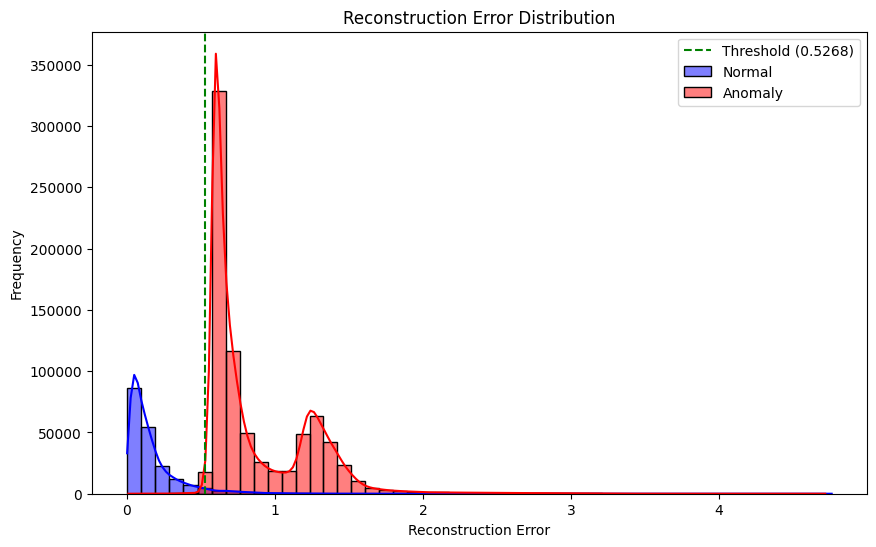

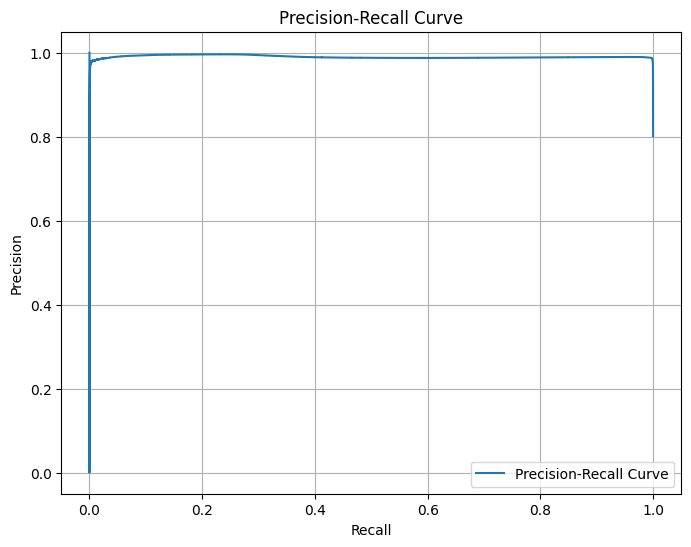

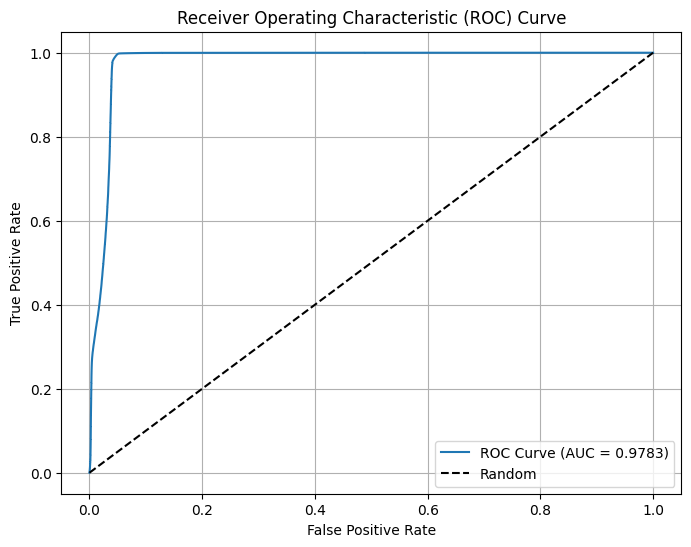

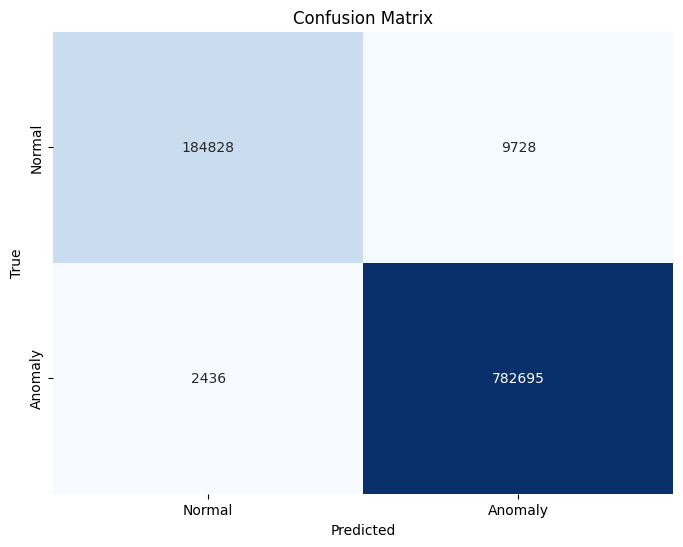

In [1]:
# Import necessary libraries
# On Complete Dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import requests
import gzip
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Function to load full KDD99 dataset
def load_kdd99():
    url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
    response = requests.get(url)
    compressed_file = io.BytesIO(response.content)
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    data = pd.read_csv(decompressed_file, header=None)

    # Define column names (based on KDD99 documentation)
    columns = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
        'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
        'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
    ]
    data.columns = columns
    return data

# Load and preprocess the dataset
data = load_kdd99()
print("Dataset loaded. Shape:", data.shape)

# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Encode labels (normal vs anomaly)
data['label'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Robust normalization with clipping to handle outliers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clip extreme values to prevent numerical instability
X_scaled = np.clip(X_scaled, -5, 5).astype(np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# VAE Model Definition
class VAE(Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim)  # Mean + log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        # Clip logvar to prevent numerical instability
        logvar = tf.clip_by_value(logvar, -10.0, 10.0)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * logvar) * eps

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, logvar

# Custom VAE loss function with KL annealing
def vae_loss(x, x_reconstructed, mean, logvar, kl_weight=1.0):
    x = tf.cast(x, tf.float32)
    x_reconstructed = tf.cast(x_reconstructed, tf.float32)

    # Reconstruction loss (MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_reconstructed), axis=1)

    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)

    # Combine with KL weight
    total_loss = tf.reduce_mean(reconstruction_loss + kl_weight * kl_loss)

    return total_loss, reconstruction_loss, kl_loss

# Training step
@tf.function
def train_step(model, x, optimizer, kl_weight):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        total_loss, recon_loss, kl_loss = vae_loss(x, x_reconstructed, mean, logvar, kl_weight)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    # Clip gradients to prevent explosion
    gradients = [tf.clip_by_value(g, -5.0, 5.0) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, recon_loss, kl_loss

# Training the VAE
input_dim = X_train.shape[1]
latent_dim = 8
vae = VAE(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Lowered learning rate

epochs = 20
batch_size = 256
kl_weight_start = 0.1
kl_weight_end = 1.0
kl_weight_step = (kl_weight_end - kl_weight_start) / epochs

print("Training VAE...")
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train only on normal data
    normal_train_data = X_train[y_train == 0]
    dataset = tf.data.Dataset.from_tensor_slices(normal_train_data).shuffle(1000).batch(batch_size)
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    num_batches = 0

    # Anneal KL weight
    kl_weight = kl_weight_start + (epoch * kl_weight_step)

    for batch in dataset:
        loss, recon_loss, kl_loss = train_step(vae, batch, optimizer, kl_weight)
        total_loss += loss
        total_recon_loss += tf.reduce_mean(recon_loss)
        total_kl_loss += tf.reduce_mean(kl_loss)
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches
    print(f"Average total loss: {avg_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}, KL loss: {avg_kl_loss:.4f}, KL weight: {kl_weight:.4f}")

# Anomaly Detection
def compute_reconstruction_error(model, x):
    x = tf.cast(x, tf.float32)
    x_reconstructed, _, _ = model(x)
    return np.mean(np.square(x - x_reconstructed), axis=1)

# Evaluate on test set
print("Evaluating model...")
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
reconstruction_errors = compute_reconstruction_error(vae, X_test_tensor)

# Determine threshold (95th percentile of normal data errors)
normal_errors = reconstruction_errors[y_test == 0]
threshold = np.percentile(normal_errors, 95)
print(f"Anomaly detection threshold: {threshold:.4f}")

# Predict anomalies
y_pred = (reconstruction_errors > threshold).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualizations

# 1. Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors[y_test == 0], bins=50, color='blue', label='Normal', kde=True, alpha=0.5)
sns.histplot(reconstruction_errors[y_test == 1], bins=50, color='red', label='Anomaly', kde=True, alpha=0.5)
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, reconstruction_errors)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
auc_score = roc_auc_score(y_test, reconstruction_errors)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()